In [1]:
DEMOGRAPHICS_PATIENTS = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/ShunSasai_SCP_clean/scripts/utils/subj_list/subject_list_patient_COBRE.mat'
DEMOGRAPHICS_CONTROLS = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/ShunSasai_SCP_clean/scripts/utils/subj_list/subject_list_control_COBRE.mat'
STRUCTURAL_DERIVATIVES = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/Schizconnect_raw_data/COBRE/COBREqsirecon/derivatives/qsirecon-MRtrix3_fork-SS3T_act-HSVS'
FUNCTIONAL_DERIVATIVES = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/Schizconnect_raw_data/COBRE/COBRExcpd/'
# ATLASES = ['4S156', '4S256', '4S456']
ATLASES = ['4S156']
ATLAS = ATLASES[0]

def print2(expression: str):
    print('>>> ' + expression)
    print(eval(expression))
    print()

In [7]:
%%time

from bids import BIDSLayout, BIDSLayoutIndexer

indexer = BIDSLayoutIndexer(validate=False, index_metadata=False)

structural_derivatives = BIDSLayout(
    STRUCTURAL_DERIVATIVES,
    indexer=indexer,
)

functional_derivatives = BIDSLayout(
    FUNCTIONAL_DERIVATIVES,
    indexer=indexer,
)

CPU times: user 13.1 s, sys: 455 ms, total: 13.5 s
Wall time: 49.2 s


In [8]:
import importlib
import schiz_wholebrain
importlib.reload(schiz_wholebrain)
from schiz_wholebrain.subject import Subject

# A `Subject` is made of a subject label and (optionally) connectivity
# and demographics data:

A00024160 = Subject(
    'A00024160',
    structural_session_label = '20090101',
    structural_derivatives = structural_derivatives.root,
    functional_session_label = '20090101',
    functional_derivatives = functional_derivatives.root,
    atlases = ATLASES,
    demographics = {'diagnosis': 'sick', 'country': 'XYZ', 'height': 1.8},
)

print2('A00024160')
print2('A00024160.demographics')

print2('A00024160.functional_session')
print2('A00024160.functional_connectivity[ATLAS]')
print2('A00024160.structural_session')
print2('A00024160.structural_connectivity[ATLAS]')


>>> A00024160
Subject(A00024160, sick)

>>> A00024160.demographics
{'diagnosis': 'sick', 'country': 'XYZ', 'height': 1.8}

>>> A00024160.functional_session
20090101

>>> A00024160.functional_connectivity[ATLAS]
FunctionalConnectivity

>>> A00024160.structural_session
20090101

>>> A00024160.structural_connectivity[ATLAS]
StructuralConnectivity



In [9]:
import importlib
from schiz_wholebrain.cohort import Cohort
importlib.reload(schiz_wholebrain)
from schiz_wholebrain.cohort import Cohort

# Cohorts can be created by passing an Iterable of Subjects:
mycohort = Cohort([A00024160])
print2('mycohort')

# Or by calling the special method `Cohort.cohort_from_data()`, to go
# straight from data paths and BIDS layouts to a Cohort pre-filled
# with Subjects.

patients = Cohort.cohort_from_data(
    DEMOGRAPHICS_PATIENTS,
    structural_derivatives,
    functional_derivatives,
    ATLASES,
    sample_size=None,
)

>>> mycohort
Cohort({Subject(A00024160, sick)})



  0% 0/43 [00:00<?, ?it/s]

 26% 11/43 [00:01<00:05,  6.22it/s]

 28% 12/43 [00:07<00:23,  1.32it/s]

 30% 13/43 [00:09<00:29,  1.03it/s]

 35% 15/43 [00:11<00:26,  1.04it/s]

 37% 16/43 [00:12<00:26,  1.01it/s]

 40% 17/43 [00:13<00:26,  1.03s/it]

 42% 18/43 [00:16<00:33,  1.35s/it]

 47% 20/43 [00:20<00:37,  1.65s/it]

 53% 23/43 [00:23<00:29,  1.45s/it]

 56% 24/43 [00:25<00:26,  1.38s/it]

 58% 25/43 [00:36<01:01,  3.42s/it]

 60% 26/43 [00:36<00:45,  2.69s/it]

 63% 27/43 [00:38<00:39,  2.44s/it]

 65% 28/43 [00:38<00:27,  1.85s/it]

 67% 29/43 [00:48<00:55,  3.95s/it]

 72% 31/43 [00:51<00:34,  2.91s/it]

 74% 32/43 [00:51<00:25,  2.33s/it]

 77% 33/43 [00:51<00:17,  1.77s/it]

 79% 34/43 [00:52<00:14,  1.58s/it]

 81% 35/43 [00:55<00:13,  1.74s/it]

 84% 36/43 [00:56<00:12,  1.79s/it]

 86% 37/43 [00:57<00:08,  1.46s/it]

 88% 38/43 [00:58<00:06,  1.30s/it]

 95% 41/43 [00:58<00:01,  1.63it/s]

 98% 42/43 [00:59<00:00,  1.65it/s]

100% 43/43 [00:59<00:00,  1.94it/s]

100% 43/43 [00:59<00:00,  1.38s/it]

In [10]:
controls = Cohort.cohort_from_data(
    DEMOGRAPHICS_CONTROLS,
    structural_derivatives,
    functional_derivatives,
    ATLASES,
    sample_size=None,
)

  0% 0/55 [00:00<?, ?it/s]

 40% 22/55 [00:04<00:07,  4.44it/s]

 42% 23/55 [00:05<00:08,  3.99it/s]

 45% 25/55 [00:27<00:54,  1.81s/it]

 47% 26/55 [00:32<01:02,  2.15s/it]

 49% 27/55 [00:33<00:57,  2.04s/it]

 53% 29/55 [00:43<01:12,  2.80s/it]

 55% 30/55 [00:44<01:02,  2.49s/it]

 58% 32/55 [00:52<01:06,  2.89s/it]

 60% 33/55 [00:54<01:02,  2.83s/it]

 62% 34/55 [00:55<00:52,  2.50s/it]

 65% 36/55 [00:58<00:39,  2.09s/it]

 67% 37/55 [00:59<00:31,  1.77s/it]

 73% 40/55 [01:00<00:16,  1.11s/it]

 75% 41/55 [01:02<00:19,  1.38s/it]

 76% 42/55 [01:04<00:17,  1.34s/it]

 78% 43/55 [01:04<00:12,  1.08s/it]

 80% 44/55 [01:05<00:11,  1.02s/it]

 82% 45/55 [01:05<00:09,  1.08it/s]

 84% 46/55 [01:06<00:07,  1.13it/s]

 85% 47/55 [01:07<00:07,  1.13it/s]

 87% 48/55 [01:07<00:05,  1.32it/s]

 89% 49/55 [01:13<00:12,  2.09s/it]

 91% 50/55 [01:14<00:09,  1.80s/it]

 95% 52/55 [01:15<00:03,  1.12s/it]

 96% 53/55 [01:16<00:02,  1.23s/it]

 98% 54/55 [01:16<00:00,  1.04it/s]

100% 55/55 [01:16<00:00,  1.33it/s]

100% 55/55 [01:16<00:00,  1.40s/it]

In [11]:
print2("f'{len(patients)} patients and {len(controls)} controls.'")

# Cohorts also support simple indexing by label:
A00021058 = controls['A00021058']
print('A00021058')

# Cohorts behave like sets, relying on subject labels for element uniqueness:
print2('set.intersection(patients, controls)')

print2("f'{len(set.union(patients, controls))} subjects in total.'")

print2("A00021058 in controls")
# Same as:
print2("'A00021058' in controls")

>>> f'{len(patients)} patients and {len(controls)} controls.'
43 patients and 55 controls.

A00021058
>>> set.intersection(patients, controls)
set()

>>> f'{len(set.union(patients, controls))} subjects in total.'
98 subjects in total.

>>> A00021058 in controls
True

>>> 'A00021058' in controls
True



In [47]:
# A Cohort subset can be derived by calling `Cohort.filter()` and passing an
# arbitrary function describing the condition to be met for single subjects.
# This is syntactic sugar for:
#     `subcohort = Cohort(filter(condition, cohort))`

def filter_by_motion(subject):
    threshold = 0.5
    return subject.functional_connectivity[ATLAS].motion_outliers_ratio < threshold

low_motion_patients = patients.filter(filter_by_motion)
low_motion_controls = controls.filter(filter_by_motion)

print2("f'{len(low_motion_patients)} patients and {len(low_motion_controls)} controls.'")

print2('low_motion_controls.labels')

# Arbitrary Subject attributes can be easily collected for the whole Cohort...
demographics = low_motion_patients.collect("demographics", subject_labels=True)
print2('demographics')
print2('dict(list(demographics)[0:3])')

# ...this supports attributes deep-nested within Subjects:
attribute = f"connectivity_{ATLAS}.functional.motion_outliers_ratio"
print2('attribute')
print2('list(low_motion_patients.collect(attribute))')

>>> f'{len(low_motion_patients)} patients and {len(low_motion_controls)} controls.'
37 patients and 52 controls.

>>> low_motion_controls.labels
{'A00023330', 'A00022810', 'A00021081', 'A00023848', 'A00022915', 'A00023800', 'A00024372', 'A00011265', 'A00022592', 'A00023120', 'A00020968', 'A00024932', 'A00003150', 'A00022400', 'A00027787', 'A00014225', 'A00022773', 'A00013816', 'A00022835', 'A00021058', 'A00028052', 'A00022687', 'A00024955', 'A00021085', 'A00023337', 'A00014898', 'A00011725', 'A00019888', 'A00023095', 'A00024546', 'A00026945', 'A00013140', 'A00022653', 'A00020895', 'A00023131', 'A00023866', 'A00015826', 'A00014522', 'A00010684', 'A00018553', 'A00024446', 'A00022509', 'A00024663', 'A00022837', 'A00024535', 'A00021072', 'A00025969', 'A00020984', 'A00022490', 'A00024160', 'A00024301', 'A00004087'}

>>> demographics
<generator object Cohort.collect at 0x7bf301ba6e40>

>>> dict(list(demographics)[0:3])
{'A00017147': {'age': 49, 'sex': 'male', 'subdiagnosis': 'Schizophrenia_S

In [48]:
import numpy as np
import importlib
from schiz_wholebrain import quantities
importlib.reload(quantities)
from schiz_wholebrain.quantities import (
    aln_model, aln_functional_connectivity, matrix2matrix_correlation
)

# The `quantities` module contains functions which operate on whole subjects.
# `Subject.compute()` is a convenience function which automatically
# stores the result in a dictionary called `Subject.quantities`.
# A similar interface called `Cohort.compute()` exists to process and
# store the quantity in parallel for whole cohorts.

def compute_cohort_connectivity_correlations(
        cohort,
        bandpass=None,
        sampling_rate=None
):
    # Correlations with structural connectivity.

    cohort.compute(
        matrix2matrix_correlation,
        key='structure_function_correlation',
        max_workers=1,
        matrix1=f'connectivity_{ATLAS}.structural.raw_count',
        matrix2=f'connectivity_{ATLAS}.functional.correlation_matrix',
    )

    # Correlations with simulated functional connectivity.

    cohort.compute(aln_model, duration=300)
    cohort.compute(
        aln_functional_connectivity,
        max_workers=1,
        transient=12,
        bandpass=bandpass,
        sampling_rate=sampling_rate,
    )
    cohort.compute(
        matrix2matrix_correlation,
        max_workers=1,
        key='aln_correlation',
        matrix1=f'quantities[aln_functional_connectivity]',
        matrix2=f'connectivity_{ATLAS}.functional.correlation_matrix',
    )

    # Correlations with simulated functional connectivity, based on cohort's
    # mean structural connectivity.

    counts = cohort.collect(f"connectivity_{ATLAS}.structural.raw_count")
    lengths = cohort.collect(f"connectivity_{ATLAS}.structural.mean_length")
    mean_count = np.stack(list(counts), axis=-1).mean(axis=-1)
    mean_length = np.stack(list(lengths), axis=-1).mean(axis=-1)

    # Add cohort's mean structural connectivity to each subject.
    for subject in cohort:
        subject.quantities['cohort_mean_raw_count'] = mean_count
        subject.quantities['cohort_mean_mean_length'] = mean_length

    cohort.compute(
        aln_model,
        key='aln_model_cohort_mean',
        duration=300,
        mean_structural=True
    )
    cohort.compute(
        aln_functional_connectivity,
        key='aln_functional_connectivity_cohort_mean',
        max_workers=1,
        model_key='aln_model_cohort_mean',
        transient=12,
        bandpass=bandpass,
        sampling_rate=sampling_rate,
    )
    cohort.compute(
        matrix2matrix_correlation,
        key='aln_correlation_cohort_mean',
        max_workers=1,
        matrix1=f'quantities[aln_functional_connectivity_cohort_mean]',
        matrix2=f'connectivity_{ATLAS}.functional.correlation_matrix',
    )


In [49]:
compute_cohort_connectivity_correlations(
    low_motion_patients,
    bandpass=(0.01, 0.1),
    sampling_rate=0.5
)
compute_cohort_connectivity_correlations(
    low_motion_controls,
    bandpass=(0.01, 0.1),
    sampling_rate=0.5
)

  0% 0/37 [00:00<?, ?it/s]

100% 37/37 [00:00<00:00, 779.39it/s]

  0% 0/37 [00:00<?, ?it/s]

  3% 1/37 [06:03<3:38:08, 363.57s/it]

  5% 2/37 [06:08<1:28:52, 152.36s/it]

  8% 3/37 [06:08<46:59, 82.93s/it]   

 11% 4/37 [06:09<27:47, 50.54s/it]

 14% 5/37 [06:09<17:21, 32.54s/it]

 16% 6/37 [06:16<12:17, 23.78s/it]

 19% 7/37 [06:17<08:03, 16.11s/it]

 22% 8/37 [06:18<05:34, 11.53s/it]

 24% 9/37 [06:23<04:20,  9.32s/it]

 27% 10/37 [06:26<03:24,  7.58s/it]

 30% 11/37 [06:27<02:20,  5.40s/it]

 32% 12/37 [06:39<03:09,  7.59s/it]

 35% 13/37 [06:41<02:16,  5.69s/it]

 38% 14/37 [06:46<02:09,  5.62s/it]

 41% 15/37 [06:50<01:52,  5.10s/it]

 43% 16/37 [06:56<01:50,  5.25s/it]

 46% 17/37 [06:56<01:16,  3.81s/it]

 49% 18/37 [07:00<01:15,  3.97s/it]

 51% 19/37 [14:59<43:57, 146.51s/it]

 54% 20/37 [15:11<30:05, 106.23s/it]

 57% 21/37 [15:13<19:57, 74.85s/it] 

 59% 22/37 [15:14<13:09, 52.64s/it]

 62% 23/37 [15:18<08:54, 38.18s/it]

 65% 24/37 [15:19<05:50, 26.99s/it]

 68% 25/37 [15:20<03:48, 19.02s/it]

 70% 26/37 [15:21<02:30, 13.68s/it]

 73% 27/37 [15:24<01:44, 10.45s/it]

 76% 28/37 [15:26<01:12,  8.06s/it]

 78% 29/37 [15:33<01:01,  7.70s/it]

 81% 30/37 [15:34<00:39,  5.63s/it]

 84% 31/37 [15:42<00:38,  6.45s/it]

 86% 32/37 [15:43<00:23,  4.64s/it]

 89% 33/37 [15:46<00:16,  4.24s/it]

 92% 34/37 [15:49<00:11,  3.74s/it]

 95% 35/37 [15:52<00:07,  3.62s/it]

 97% 36/37 [15:58<00:04,  4.47s/it]

100% 37/37 [17:36<00:00, 32.40s/it]

100% 37/37 [17:36<00:00, 28.55s/it]

  0%|                                        | 0/37 [00:00<?, ?it/s]

  5%|█▋                              | 2/37 [00:00<00:03, 11.29it/s]

 11%|███▍                            | 4/37 [00:00<00:02, 12.58it/s]

 16%|█████▏                          | 6/37 [00:00<00:02, 13.35it/s]

 22%|██████▉                         | 8/37 [00:00<00:02, 14.02it/s]

 27%|████████▍                      | 10/37 [00:00<00:01, 14.28it/s]

 32%|██████████                     | 12/37 [00:00<00:01, 14.65it/s]

 38%|███████████▋                   | 14/37 [00:00<00:01, 14.57it/s]

 43%|█████████████▍                 | 16/37 [00:01<00:01, 14.74it/s]

 49%|███████████████                | 18/37 [00:01<00:01, 14.87it/s]

 54%|████████████████▊              | 20/37 [00:01<00:01, 15.02it/s]

 59%|██████████████████▍            | 22/37 [00:01<00:00, 15.01it/s]

 65%|████████████████████           | 24/37 [00:01<00:00, 15.13it/s]

 70%|█████████████████████▊         | 26/37 [00:01<00:00, 15.13it/s]

 76%|███████████████████████▍       | 28/37 [00:01<00:00, 15.17it/s]

 81%|█████████████████████████▏     | 30/37 [00:02<00:00, 15.26it/s]

 86%|██████████████████████████▊    | 32/37 [00:02<00:00, 15.42it/s]

 92%|████████████████████████████▍  | 34/37 [00:02<00:00, 15.46it/s]

 97%|██████████████████████████████▏| 36/37 [00:02<00:00, 15.47it/s]

100%|███████████████████████████████| 37/37 [00:02<00:00, 14.87it/s]

  0%|                                        | 0/37 [00:00<?, ?it/s]

  5%|█▋                              | 2/37 [00:00<00:02, 14.33it/s]

 11%|███▍                            | 4/37 [00:00<00:02, 15.28it/s]

 16%|█████▏                          | 6/37 [00:00<00:01, 15.60it/s]

 22%|██████▉                         | 8/37 [00:00<00:01, 15.87it/s]

 27%|████████▍                      | 10/37 [00:00<00:01, 15.68it/s]

 32%|██████████                     | 12/37 [00:00<00:01, 15.55it/s]

 38%|███████████▋                   | 14/37 [00:00<00:01, 15.49it/s]

 43%|█████████████▍                 | 16/37 [00:01<00:01, 15.55it/s]

 49%|███████████████                | 18/37 [00:01<00:01, 14.83it/s]

 54%|████████████████▊              | 20/37 [00:01<00:01, 14.13it/s]

 59%|██████████████████▍            | 22/37 [00:01<00:01, 13.96it/s]

 65%|████████████████████           | 24/37 [00:01<00:00, 13.45it/s]

 70%|█████████████████████▊         | 26/37 [00:01<00:00, 12.86it/s]

 76%|███████████████████████▍       | 28/37 [00:01<00:00, 12.73it/s]

 81%|█████████████████████████▏     | 30/37 [00:02<00:00, 12.62it/s]

 86%|██████████████████████████▊    | 32/37 [00:02<00:00, 12.64it/s]

 92%|████████████████████████████▍  | 34/37 [00:02<00:00, 12.65it/s]

 97%|██████████████████████████████▏| 36/37 [00:02<00:00, 12.86it/s]

100%|███████████████████████████████| 37/37 [00:02<00:00, 13.90it/s]

  0%|                                        | 0/37 [00:00<?, ?it/s]

  3%|▊                            | 1/37 [08:50<5:18:00, 530.00s/it]

  5%|█▌                           | 2/37 [09:10<2:14:21, 230.32s/it]

  8%|██▎                          | 3/37 [09:14<1:11:50, 126.79s/it]

 11%|███▍                            | 4/37 [09:23<44:12, 80.38s/it]

 14%|████▎                           | 5/37 [09:45<31:38, 59.32s/it]

 16%|█████▏                          | 6/37 [09:47<20:32, 39.74s/it]

 19%|██████                          | 7/37 [10:04<16:13, 32.46s/it]

 22%|██████▉                         | 8/37 [10:05<10:49, 22.38s/it]

 24%|███████▊                        | 9/37 [10:25<10:11, 21.83s/it]

 27%|████████▍                      | 10/37 [10:27<06:56, 15.43s/it]

 30%|█████████▏                     | 11/37 [10:30<05:07, 11.81s/it]

 32%|██████████                     | 12/37 [10:31<03:32,  8.52s/it]

 35%|██████████▉                    | 13/37 [10:42<03:37,  9.08s/it]

 38%|███████████▋                   | 14/37 [10:42<02:29,  6.50s/it]

 41%|████████████▌                  | 15/37 [10:43<01:42,  4.67s/it]

 43%|█████████████▍                 | 16/37 [10:57<02:43,  7.77s/it]

 46%|██████████████▏                | 17/37 [11:21<04:11, 12.60s/it]

 49%|███████████████                | 18/37 [11:33<03:52, 12.24s/it]

 51%|███████████████▍              | 19/37 [18:09<38:17, 127.62s/it]

 54%|████████████████▊              | 20/37 [18:29<26:58, 95.22s/it]

 57%|█████████████████▌             | 21/37 [19:01<20:19, 76.23s/it]

 59%|██████████████████▍            | 22/37 [19:06<13:42, 54.86s/it]

 62%|███████████████████▎           | 23/37 [19:33<10:53, 46.65s/it]

 65%|████████████████████           | 24/37 [19:36<07:16, 33.55s/it]

 68%|████████████████████▉          | 25/37 [19:53<05:41, 28.43s/it]

 70%|█████████████████████▊         | 26/37 [19:57<03:52, 21.12s/it]

 73%|██████████████████████▌        | 27/37 [19:57<02:29, 14.93s/it]

 76%|███████████████████████▍       | 28/37 [19:58<01:36, 10.77s/it]

 78%|████████████████████████▎      | 29/37 [20:06<01:18,  9.87s/it]

 81%|█████████████████████████▏     | 30/37 [20:11<00:58,  8.29s/it]

 84%|█████████████████████████▉     | 31/37 [20:15<00:43,  7.20s/it]

 86%|██████████████████████████▊    | 32/37 [20:20<00:31,  6.38s/it]

 89%|███████████████████████████▋   | 33/37 [20:22<00:20,  5.07s/it]

 92%|████████████████████████████▍  | 34/37 [20:28<00:16,  5.38s/it]

 95%|█████████████████████████████▎ | 35/37 [20:42<00:16,  8.11s/it]

 97%|██████████████████████████████▏| 36/37 [20:44<00:06,  6.09s/it]

100%|███████████████████████████████| 37/37 [21:47<00:00, 23.31s/it]

100%|███████████████████████████████| 37/37 [21:47<00:00, 35.35s/it]

  0%|                                        | 0/37 [00:00<?, ?it/s]

  3%|▊                               | 1/37 [00:00<00:12,  2.90it/s]

  5%|█▋                              | 2/37 [00:00<00:10,  3.22it/s]

  8%|██▌                             | 3/37 [00:00<00:09,  3.45it/s]

 11%|███▍                            | 4/37 [00:01<00:09,  3.49it/s]

 14%|████▎                           | 5/37 [00:01<00:08,  3.57it/s]

 16%|█████▏                          | 6/37 [00:01<00:08,  3.63it/s]

 19%|██████                          | 7/37 [00:01<00:08,  3.69it/s]

 22%|██████▉                         | 8/37 [00:02<00:07,  3.68it/s]

 24%|███████▊                        | 9/37 [00:02<00:07,  3.68it/s]

 27%|████████▍                      | 10/37 [00:02<00:07,  3.68it/s]

 30%|█████████▏                     | 11/37 [00:03<00:07,  3.65it/s]

 32%|██████████                     | 12/37 [00:03<00:06,  3.63it/s]

 35%|██████████▉                    | 13/37 [00:03<00:06,  3.60it/s]

 38%|███████████▋                   | 14/37 [00:03<00:06,  3.62it/s]

 41%|████████████▌                  | 15/37 [00:04<00:06,  3.59it/s]

 43%|█████████████▍                 | 16/37 [00:04<00:05,  3.68it/s]

 46%|██████████████▏                | 17/37 [00:04<00:05,  3.72it/s]

 49%|███████████████                | 18/37 [00:04<00:05,  3.75it/s]

 51%|███████████████▉               | 19/37 [00:05<00:04,  3.74it/s]

 54%|████████████████▊              | 20/37 [00:05<00:04,  3.73it/s]

 57%|█████████████████▌             | 21/37 [00:05<00:04,  3.73it/s]

 59%|██████████████████▍            | 22/37 [00:06<00:04,  3.67it/s]

 62%|███████████████████▎           | 23/37 [00:06<00:03,  3.75it/s]

 65%|████████████████████           | 24/37 [00:06<00:03,  3.86it/s]

 68%|████████████████████▉          | 25/37 [00:06<00:03,  4.00it/s]

 70%|█████████████████████▊         | 26/37 [00:07<00:02,  4.10it/s]

 73%|██████████████████████▌        | 27/37 [00:07<00:02,  4.24it/s]

 76%|███████████████████████▍       | 28/37 [00:07<00:02,  4.33it/s]

 78%|████████████████████████▎      | 29/37 [00:07<00:01,  4.42it/s]

 81%|█████████████████████████▏     | 30/37 [00:07<00:01,  4.48it/s]

 84%|█████████████████████████▉     | 31/37 [00:08<00:01,  4.56it/s]

 86%|██████████████████████████▊    | 32/37 [00:08<00:01,  4.60it/s]

 89%|███████████████████████████▋   | 33/37 [00:08<00:00,  4.59it/s]

 92%|████████████████████████████▍  | 34/37 [00:08<00:00,  4.65it/s]

 95%|█████████████████████████████▎ | 35/37 [00:08<00:00,  4.58it/s]

 97%|██████████████████████████████▏| 36/37 [00:09<00:00,  4.62it/s]

100%|███████████████████████████████| 37/37 [00:09<00:00,  4.80it/s]

100%|███████████████████████████████| 37/37 [00:09<00:00,  3.95it/s]

  0%|                                        | 0/37 [00:00<?, ?it/s]

  3%|▊                               | 1/37 [00:00<00:10,  3.34it/s]

  5%|█▋                              | 2/37 [00:00<00:08,  4.10it/s]

  8%|██▌                             | 3/37 [00:00<00:07,  4.39it/s]

 11%|███▍                            | 4/37 [00:00<00:07,  4.53it/s]

 14%|████▎                           | 5/37 [00:01<00:06,  4.61it/s]

 16%|█████▏                          | 6/37 [00:01<00:06,  4.72it/s]

 19%|██████                          | 7/37 [00:01<00:06,  4.71it/s]

 22%|██████▉                         | 8/37 [00:01<00:06,  4.73it/s]

 24%|███████▊                        | 9/37 [00:01<00:05,  4.73it/s]

 27%|████████▍                      | 10/37 [00:02<00:05,  4.70it/s]

 30%|█████████▏                     | 11/37 [00:02<00:05,  4.70it/s]

 32%|██████████                     | 12/37 [00:02<00:05,  4.72it/s]

 35%|██████████▉                    | 13/37 [00:02<00:05,  4.73it/s]

 38%|███████████▋                   | 14/37 [00:03<00:04,  4.72it/s]

 41%|████████████▌                  | 15/37 [00:03<00:04,  4.77it/s]

 43%|█████████████▍                 | 16/37 [00:03<00:04,  4.84it/s]

 46%|██████████████▏                | 17/37 [00:03<00:04,  4.87it/s]

 49%|███████████████                | 18/37 [00:03<00:03,  4.88it/s]

 51%|███████████████▉               | 19/37 [00:04<00:03,  4.81it/s]

 54%|████████████████▊              | 20/37 [00:04<00:03,  4.82it/s]

 57%|█████████████████▌             | 21/37 [00:04<00:03,  4.81it/s]

 59%|██████████████████▍            | 22/37 [00:04<00:03,  4.83it/s]

 62%|███████████████████▎           | 23/37 [00:04<00:02,  4.78it/s]

 65%|████████████████████           | 24/37 [00:05<00:02,  4.78it/s]

 68%|████████████████████▉          | 25/37 [00:05<00:02,  4.78it/s]

 70%|█████████████████████▊         | 26/37 [00:05<00:02,  4.82it/s]

 73%|██████████████████████▌        | 27/37 [00:05<00:02,  4.83it/s]

 76%|███████████████████████▍       | 28/37 [00:05<00:01,  4.80it/s]

 78%|████████████████████████▎      | 29/37 [00:06<00:01,  4.79it/s]

 81%|█████████████████████████▏     | 30/37 [00:06<00:01,  4.84it/s]

 84%|█████████████████████████▉     | 31/37 [00:06<00:01,  4.75it/s]

 86%|██████████████████████████▊    | 32/37 [00:06<00:01,  4.72it/s]

 89%|███████████████████████████▋   | 33/37 [00:06<00:00,  4.77it/s]

 92%|████████████████████████████▍  | 34/37 [00:07<00:00,  4.76it/s]

 95%|█████████████████████████████▎ | 35/37 [00:07<00:00,  4.62it/s]

 97%|██████████████████████████████▏| 36/37 [00:07<00:00,  4.48it/s]

100%|███████████████████████████████| 37/37 [00:07<00:00,  4.61it/s]

100%|███████████████████████████████| 37/37 [00:07<00:00,  4.70it/s]

  0%|                                        | 0/52 [00:00<?, ?it/s]

100%|██████████████████████████████| 52/52 [00:00<00:00, 578.16it/s]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                            | 1/52 [09:39<8:12:57, 579.94s/it]

  4%|█                            | 2/52 [10:26<3:41:50, 266.21s/it]

  6%|█▋                           | 3/52 [10:28<1:58:56, 145.65s/it]

  8%|██▎                           | 4/52 [10:29<1:10:49, 88.53s/it]

 10%|███                             | 5/52 [10:31<44:53, 57.31s/it]

 12%|███▋                            | 6/52 [10:32<29:15, 38.16s/it]

 13%|████▎                           | 7/52 [10:36<20:09, 26.88s/it]

 15%|████▉                           | 8/52 [10:51<17:00, 23.18s/it]

 17%|█████▌                          | 9/52 [10:57<12:48, 17.87s/it]

 19%|█████▉                         | 10/52 [11:09<11:09, 15.95s/it]

 21%|██████▌                        | 11/52 [11:11<08:02, 11.76s/it]

 23%|███████▏                       | 12/52 [11:11<05:30,  8.27s/it]

 25%|███████▊                       | 13/52 [11:15<04:26,  6.83s/it]

 27%|████████▎                      | 14/52 [11:18<03:32,  5.59s/it]

 29%|████████▉                      | 15/52 [11:18<02:28,  4.02s/it]

 31%|█████████▌                     | 16/52 [11:59<09:07, 15.20s/it]

 33%|██████████▏                    | 17/52 [12:15<08:59, 15.42s/it]

 35%|██████████▋                    | 18/52 [13:22<17:30, 30.90s/it]

 37%|██████████▏                 | 19/52 [19:51<1:16:08, 138.44s/it]

 38%|██████████▊                 | 20/52 [21:11<1:04:32, 121.02s/it]

 40%|████████████▌                  | 21/52 [21:15<44:19, 85.80s/it]

 42%|█████████████                  | 22/52 [21:18<30:22, 60.75s/it]

 44%|█████████████▋                 | 23/52 [21:35<23:08, 47.87s/it]

 46%|██████████████▎                | 24/52 [21:42<16:35, 35.54s/it]

 48%|██████████████▉                | 25/52 [21:44<11:25, 25.37s/it]

 50%|███████████████▌               | 26/52 [21:45<07:49, 18.06s/it]

 52%|████████████████               | 27/52 [21:46<05:22, 12.90s/it]

 54%|████████████████▋              | 28/52 [21:59<05:10, 12.93s/it]

 56%|█████████████████▎             | 29/52 [22:04<04:06, 10.70s/it]

 58%|█████████████████▉             | 30/52 [22:14<03:52, 10.56s/it]

 60%|██████████████████▍            | 31/52 [22:16<02:48,  8.03s/it]

 62%|███████████████████            | 32/52 [22:47<04:56, 14.81s/it]

 63%|███████████████████▋           | 33/52 [22:49<03:27, 10.90s/it]

 65%|████████████████████▎          | 34/52 [23:09<04:04, 13.57s/it]

 67%|████████████████████▊          | 35/52 [23:24<03:58, 14.01s/it]

 69%|█████████████████████▍         | 36/52 [24:31<07:58, 29.90s/it]

 71%|█████████████████████▎        | 37/52 [30:45<33:17, 133.20s/it]

 73%|██████████████████████▋        | 38/52 [30:48<21:59, 94.22s/it]

 75%|███████████████████████▎       | 39/52 [30:54<14:41, 67.83s/it]

 77%|███████████████████████▊       | 40/52 [31:40<12:12, 61.01s/it]

 79%|████████████████████████▍      | 41/52 [31:48<08:18, 45.32s/it]

 81%|█████████████████████████      | 42/52 [31:50<05:21, 32.20s/it]

 83%|█████████████████████████▋     | 43/52 [31:50<03:24, 22.71s/it]

 85%|██████████████████████████▏    | 44/52 [31:57<02:22, 17.84s/it]

 87%|██████████████████████████▊    | 45/52 [31:57<01:28, 12.58s/it]

 88%|███████████████████████████▍   | 46/52 [32:04<01:04, 10.82s/it]

 90%|████████████████████████████   | 47/52 [32:08<00:44,  8.90s/it]

 92%|████████████████████████████▌  | 48/52 [32:16<00:33,  8.48s/it]

 94%|█████████████████████████████▏ | 49/52 [32:18<00:19,  6.47s/it]

 96%|█████████████████████████████▊ | 50/52 [32:18<00:09,  4.72s/it]

 98%|██████████████████████████████▍| 51/52 [32:18<00:03,  3.35s/it]

100%|███████████████████████████████| 52/52 [32:32<00:00,  6.50s/it]

100%|███████████████████████████████| 52/52 [32:32<00:00, 37.55s/it]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                               | 1/52 [00:00<00:05,  8.52it/s]

  6%|█▊                              | 3/52 [00:00<00:04,  9.84it/s]

 10%|███                             | 5/52 [00:00<00:04, 10.19it/s]

 13%|████▎                           | 7/52 [00:00<00:04, 10.12it/s]

 17%|█████▌                          | 9/52 [00:00<00:04, 10.15it/s]

 21%|██████▌                        | 11/52 [00:01<00:04, 10.20it/s]

 25%|███████▊                       | 13/52 [00:01<00:03, 10.10it/s]

 29%|████████▉                      | 15/52 [00:01<00:03, 10.14it/s]

 33%|██████████▏                    | 17/52 [00:01<00:03, 10.22it/s]

 37%|███████████▎                   | 19/52 [00:01<00:03, 10.34it/s]

 40%|████████████▌                  | 21/52 [00:02<00:02, 10.46it/s]

 44%|█████████████▋                 | 23/52 [00:02<00:02, 10.43it/s]

 48%|██████████████▉                | 25/52 [00:02<00:02, 10.40it/s]

 52%|████████████████               | 27/52 [00:02<00:02, 10.33it/s]

 56%|█████████████████▎             | 29/52 [00:02<00:02, 10.26it/s]

 60%|██████████████████▍            | 31/52 [00:03<00:02, 10.26it/s]

 63%|███████████████████▋           | 33/52 [00:03<00:01, 10.15it/s]

 67%|████████████████████▊          | 35/52 [00:03<00:01, 10.04it/s]

 71%|██████████████████████         | 37/52 [00:03<00:01, 10.20it/s]

 75%|███████████████████████▎       | 39/52 [00:03<00:01, 10.16it/s]

 79%|████████████████████████▍      | 41/52 [00:04<00:01, 10.31it/s]

 83%|█████████████████████████▋     | 43/52 [00:04<00:00, 10.44it/s]

 87%|██████████████████████████▊    | 45/52 [00:04<00:00, 10.41it/s]

 90%|████████████████████████████   | 47/52 [00:04<00:00,  9.93it/s]

 92%|████████████████████████████▌  | 48/52 [00:04<00:00,  9.63it/s]

 94%|█████████████████████████████▏ | 49/52 [00:04<00:00,  9.29it/s]

 96%|█████████████████████████████▊ | 50/52 [00:04<00:00,  9.01it/s]

 98%|██████████████████████████████▍| 51/52 [00:05<00:00,  8.63it/s]

100%|███████████████████████████████| 52/52 [00:05<00:00,  8.56it/s]

100%|███████████████████████████████| 52/52 [00:05<00:00,  9.95it/s]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                               | 1/52 [00:00<00:08,  6.11it/s]

  4%|█▏                              | 2/52 [00:00<00:07,  6.70it/s]

  6%|█▊                              | 3/52 [00:00<00:07,  6.70it/s]

  8%|██▍                             | 4/52 [00:00<00:07,  6.72it/s]

 10%|███                             | 5/52 [00:00<00:06,  6.78it/s]

 12%|███▋                            | 6/52 [00:00<00:06,  6.80it/s]

 13%|████▎                           | 7/52 [00:01<00:06,  6.78it/s]

 15%|████▉                           | 8/52 [00:01<00:06,  6.80it/s]

 17%|█████▌                          | 9/52 [00:01<00:06,  6.82it/s]

 19%|█████▉                         | 10/52 [00:01<00:06,  6.83it/s]

 21%|██████▌                        | 11/52 [00:01<00:06,  6.70it/s]

 23%|███████▏                       | 12/52 [00:01<00:05,  6.71it/s]

 25%|███████▊                       | 13/52 [00:01<00:05,  6.67it/s]

 27%|████████▎                      | 14/52 [00:02<00:05,  6.76it/s]

 29%|████████▉                      | 15/52 [00:02<00:05,  6.71it/s]

 31%|█████████▌                     | 16/52 [00:02<00:05,  6.72it/s]

 33%|██████████▏                    | 17/52 [00:02<00:05,  6.72it/s]

 35%|██████████▋                    | 18/52 [00:02<00:05,  6.77it/s]

 37%|███████████▎                   | 19/52 [00:02<00:04,  6.76it/s]

 38%|███████████▉                   | 20/52 [00:02<00:04,  6.81it/s]

 40%|████████████▌                  | 21/52 [00:03<00:04,  6.88it/s]

 42%|█████████████                  | 22/52 [00:03<00:04,  6.93it/s]

 44%|█████████████▋                 | 23/52 [00:03<00:04,  6.60it/s]

 46%|██████████████▎                | 24/52 [00:03<00:04,  6.14it/s]

 48%|██████████████▉                | 25/52 [00:03<00:04,  5.49it/s]

 50%|███████████████▌               | 26/52 [00:04<00:05,  5.07it/s]

 52%|████████████████               | 27/52 [00:04<00:05,  4.71it/s]

 54%|████████████████▋              | 28/52 [00:04<00:05,  4.29it/s]

 56%|█████████████████▎             | 29/52 [00:04<00:05,  4.11it/s]

 58%|█████████████████▉             | 30/52 [00:05<00:05,  3.99it/s]

 60%|██████████████████▍            | 31/52 [00:05<00:05,  3.99it/s]

 62%|███████████████████            | 32/52 [00:05<00:04,  4.01it/s]

 63%|███████████████████▋           | 33/52 [00:05<00:04,  3.97it/s]

 65%|████████████████████▎          | 34/52 [00:06<00:04,  3.93it/s]

 67%|████████████████████▊          | 35/52 [00:06<00:04,  4.09it/s]

 69%|█████████████████████▍         | 36/52 [00:06<00:03,  4.36it/s]

 71%|██████████████████████         | 37/52 [00:06<00:03,  4.66it/s]

 73%|██████████████████████▋        | 38/52 [00:06<00:02,  4.91it/s]

 75%|███████████████████████▎       | 39/52 [00:07<00:02,  5.21it/s]

 77%|███████████████████████▊       | 40/52 [00:07<00:02,  5.46it/s]

 79%|████████████████████████▍      | 41/52 [00:07<00:01,  5.68it/s]

 81%|█████████████████████████      | 42/52 [00:07<00:01,  5.91it/s]

 83%|█████████████████████████▋     | 43/52 [00:07<00:01,  6.11it/s]

 85%|██████████████████████████▏    | 44/52 [00:07<00:01,  6.26it/s]

 87%|██████████████████████████▊    | 45/52 [00:08<00:01,  6.48it/s]

 88%|███████████████████████████▍   | 46/52 [00:08<00:00,  6.59it/s]

 90%|████████████████████████████   | 47/52 [00:08<00:00,  6.67it/s]

 92%|████████████████████████████▌  | 48/52 [00:08<00:00,  6.70it/s]

 94%|█████████████████████████████▏ | 49/52 [00:08<00:00,  6.78it/s]

 96%|█████████████████████████████▊ | 50/52 [00:08<00:00,  6.88it/s]

 98%|██████████████████████████████▍| 51/52 [00:08<00:00,  6.93it/s]

100%|███████████████████████████████| 52/52 [00:08<00:00,  7.24it/s]

100%|███████████████████████████████| 52/52 [00:08<00:00,  5.78it/s]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                            | 1/52 [10:36<9:00:36, 636.01s/it]

  4%|█                            | 2/52 [10:39<3:39:59, 263.99s/it]

  6%|█▋                           | 3/52 [10:43<1:58:37, 145.26s/it]

  8%|██▎                           | 4/52 [11:01<1:16:01, 95.02s/it]

 10%|███                             | 5/52 [11:08<49:37, 63.34s/it]

 12%|███▋                            | 6/52 [11:19<34:52, 45.49s/it]

 13%|████▎                           | 7/52 [11:28<25:03, 33.41s/it]

 15%|████▉                           | 8/52 [11:29<17:00, 23.20s/it]

 17%|█████▌                          | 9/52 [11:42<14:17, 19.95s/it]

 19%|█████▉                         | 10/52 [11:43<09:57, 14.24s/it]

 21%|██████▌                        | 11/52 [11:45<07:12, 10.55s/it]

 23%|███████▏                       | 12/52 [11:59<07:41, 11.55s/it]

 25%|███████▊                       | 13/52 [12:08<06:56, 10.68s/it]

 27%|████████▎                      | 14/52 [12:16<06:20, 10.00s/it]

 29%|████████▉                      | 15/52 [12:18<04:32,  7.37s/it]

 31%|█████████▌                     | 16/52 [12:32<05:37,  9.37s/it]

 33%|██████████▏                    | 17/52 [12:45<06:13, 10.68s/it]

 35%|██████████▋                    | 18/52 [13:11<08:37, 15.23s/it]

 37%|███████▋             | 19/52 [17:07:14<167:36:22, 18284.30s/it]

 38%|████████             | 20/52 [17:07:40<113:48:02, 12802.59s/it]

 40%|█████████▎             | 21/52 [17:07:47<77:10:14, 8961.76s/it]

 42%|█████████▋             | 22/52 [17:07:51<52:16:41, 6273.39s/it]

 44%|██████████▏            | 23/52 [17:07:58<35:23:12, 4392.86s/it]

 46%|██████████▌            | 24/52 [17:07:58<23:54:55, 3074.83s/it]

 48%|███████████            | 25/52 [17:08:10<16:10:08, 2155.86s/it]

 50%|███████████▌           | 26/52 [17:08:15<10:54:32, 1510.50s/it]

 52%|████████████▍           | 27/52 [17:08:16<7:20:40, 1057.61s/it]

 54%|█████████████▍           | 28/52 [17:08:20<4:56:35, 741.49s/it]

 56%|█████████████▉           | 29/52 [17:08:22<3:19:12, 519.66s/it]

 58%|██████████████▍          | 30/52 [17:08:25<2:13:39, 364.52s/it]

 60%|██████████████▉          | 31/52 [17:08:26<1:29:23, 255.40s/it]

 62%|███████████████▍         | 32/52 [17:08:38<1:00:52, 182.61s/it]

 63%|█████████████████▏         | 33/52 [17:08:42<40:48, 128.88s/it]

 65%|██████████████████▎         | 34/52 [17:08:55<28:13, 94.07s/it]

 67%|██████████████████▊         | 35/52 [17:08:58<18:56, 66.84s/it]

 69%|███████████████████▍        | 36/52 [17:09:37<15:34, 58.43s/it]

 71%|███████████████████▉        | 37/52 [17:12:46<24:27, 97.82s/it]

 73%|████████████████████▍       | 38/52 [17:13:01<17:00, 72.87s/it]

 75%|█████████████████████       | 39/52 [17:13:07<11:27, 52.86s/it]

 77%|█████████████████████▌      | 40/52 [17:13:18<08:02, 40.19s/it]

 79%|██████████████████████      | 41/52 [17:13:36<06:10, 33.66s/it]

 81%|██████████████████████▌     | 42/52 [17:13:38<04:01, 24.12s/it]

 83%|███████████████████████▏    | 43/52 [17:13:40<02:36, 17.37s/it]

 85%|███████████████████████▋    | 44/52 [17:13:41<01:39, 12.38s/it]

 87%|████████████████████████▏   | 45/52 [17:13:50<01:20, 11.45s/it]

 88%|████████████████████████▊   | 46/52 [17:13:51<00:50,  8.49s/it]

 90%|█████████████████████████▎  | 47/52 [17:13:56<00:36,  7.34s/it]

 92%|█████████████████████████▊  | 48/52 [17:13:59<00:24,  6.04s/it]

 94%|██████████████████████████▍ | 49/52 [17:14:01<00:14,  4.75s/it]

 96%|██████████████████████████▉ | 50/52 [17:14:01<00:06,  3.45s/it]

 98%|███████████████████████████▍| 51/52 [17:14:02<00:02,  2.71s/it]

100%|████████████████████████████| 52/52 [17:14:10<00:00,  4.15s/it]

100%|██████████████████████████| 52/52 [17:14:10<00:00, 1193.27s/it]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                               | 1/52 [00:00<00:23,  2.19it/s]

  4%|█▏                              | 2/52 [00:00<00:22,  2.27it/s]

  6%|█▊                              | 3/52 [00:01<00:22,  2.19it/s]

  8%|██▍                             | 4/52 [00:01<00:21,  2.23it/s]

 10%|███                             | 5/52 [00:02<00:21,  2.17it/s]

 12%|███▋                            | 6/52 [00:02<00:18,  2.43it/s]

 13%|████▎                           | 7/52 [00:02<00:17,  2.54it/s]

 15%|████▉                           | 8/52 [00:03<00:16,  2.64it/s]

 17%|█████▌                          | 9/52 [00:03<00:15,  2.79it/s]

 19%|█████▉                         | 10/52 [00:03<00:15,  2.77it/s]

 21%|██████▌                        | 11/52 [00:04<00:14,  2.88it/s]

 23%|███████▏                       | 12/52 [00:04<00:13,  2.87it/s]

 25%|███████▊                       | 13/52 [00:04<00:12,  3.18it/s]

 27%|████████▎                      | 14/52 [00:05<00:13,  2.85it/s]

 29%|████████▉                      | 15/52 [00:05<00:13,  2.74it/s]

 31%|█████████▌                     | 16/52 [00:06<00:12,  2.85it/s]

 33%|██████████▏                    | 17/52 [00:06<00:12,  2.70it/s]

 35%|██████████▋                    | 18/52 [00:06<00:11,  2.99it/s]

 37%|███████████▎                   | 19/52 [00:06<00:10,  3.23it/s]

 38%|███████████▉                   | 20/52 [00:07<00:09,  3.37it/s]

 40%|████████████▌                  | 21/52 [00:07<00:08,  3.54it/s]

 42%|█████████████                  | 22/52 [00:07<00:08,  3.47it/s]

 44%|█████████████▋                 | 23/52 [00:08<00:08,  3.58it/s]

 46%|██████████████▎                | 24/52 [00:08<00:07,  3.73it/s]

 48%|██████████████▉                | 25/52 [00:08<00:07,  3.79it/s]

 50%|███████████████▌               | 26/52 [00:08<00:06,  3.82it/s]

 52%|████████████████               | 27/52 [00:09<00:07,  3.53it/s]

 54%|████████████████▋              | 28/52 [00:09<00:07,  3.08it/s]

 56%|█████████████████▎             | 29/52 [00:09<00:07,  3.08it/s]

 58%|█████████████████▉             | 30/52 [00:10<00:07,  3.10it/s]

 60%|██████████████████▍            | 31/52 [00:10<00:06,  3.10it/s]

 62%|███████████████████            | 32/52 [00:10<00:06,  3.14it/s]

 63%|███████████████████▋           | 33/52 [00:11<00:06,  3.11it/s]

 65%|████████████████████▎          | 34/52 [00:11<00:06,  2.97it/s]

 67%|████████████████████▊          | 35/52 [00:11<00:06,  2.66it/s]

 69%|█████████████████████▍         | 36/52 [00:12<00:06,  2.57it/s]

 71%|██████████████████████         | 37/52 [00:12<00:05,  2.74it/s]

 73%|██████████████████████▋        | 38/52 [00:13<00:04,  2.87it/s]

 75%|███████████████████████▎       | 39/52 [00:13<00:04,  2.96it/s]

 77%|███████████████████████▊       | 40/52 [00:13<00:03,  3.07it/s]

 79%|████████████████████████▍      | 41/52 [00:13<00:03,  3.19it/s]

 81%|█████████████████████████      | 42/52 [00:14<00:03,  3.28it/s]

 83%|█████████████████████████▋     | 43/52 [00:14<00:02,  3.30it/s]

 85%|██████████████████████████▏    | 44/52 [00:14<00:02,  3.32it/s]

 87%|██████████████████████████▊    | 45/52 [00:15<00:02,  3.32it/s]

 88%|███████████████████████████▍   | 46/52 [00:15<00:01,  3.26it/s]

 90%|████████████████████████████   | 47/52 [00:15<00:01,  2.96it/s]

 92%|████████████████████████████▌  | 48/52 [00:16<00:01,  2.68it/s]

 94%|█████████████████████████████▏ | 49/52 [00:16<00:01,  2.56it/s]

 96%|█████████████████████████████▊ | 50/52 [00:17<00:00,  2.58it/s]

 98%|██████████████████████████████▍| 51/52 [00:17<00:00,  2.70it/s]

100%|███████████████████████████████| 52/52 [00:17<00:00,  2.85it/s]

100%|███████████████████████████████| 52/52 [00:17<00:00,  2.93it/s]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                               | 1/52 [00:00<00:16,  3.14it/s]

  4%|█▏                              | 2/52 [00:00<00:15,  3.23it/s]

  6%|█▊                              | 3/52 [00:00<00:14,  3.29it/s]

  8%|██▍                             | 4/52 [00:01<00:14,  3.36it/s]

 10%|███                             | 5/52 [00:01<00:13,  3.42it/s]

 12%|███▋                            | 6/52 [00:01<00:13,  3.49it/s]

 13%|████▎                           | 7/52 [00:02<00:12,  3.50it/s]

 15%|████▉                           | 8/52 [00:02<00:12,  3.51it/s]

 17%|█████▌                          | 9/52 [00:02<00:12,  3.52it/s]

 19%|█████▉                         | 10/52 [00:02<00:11,  3.57it/s]

 21%|██████▌                        | 11/52 [00:03<00:11,  3.59it/s]

 23%|███████▏                       | 12/52 [00:03<00:11,  3.62it/s]

 25%|███████▊                       | 13/52 [00:03<00:10,  3.59it/s]

 27%|████████▎                      | 14/52 [00:03<00:10,  3.64it/s]

 29%|████████▉                      | 15/52 [00:04<00:10,  3.67it/s]

 31%|█████████▌                     | 16/52 [00:04<00:09,  3.67it/s]

 33%|██████████▏                    | 17/52 [00:04<00:09,  3.57it/s]

 35%|██████████▋                    | 18/52 [00:05<00:09,  3.47it/s]

 37%|███████████▎                   | 19/52 [00:05<00:09,  3.37it/s]

 38%|███████████▉                   | 20/52 [00:05<00:09,  3.39it/s]

 40%|████████████▌                  | 21/52 [00:06<00:09,  3.40it/s]

 42%|█████████████                  | 22/52 [00:06<00:08,  3.42it/s]

 44%|█████████████▋                 | 23/52 [00:06<00:08,  3.41it/s]

 46%|██████████████▎                | 24/52 [00:06<00:08,  3.35it/s]

 48%|██████████████▉                | 25/52 [00:07<00:08,  3.34it/s]

 50%|███████████████▌               | 26/52 [00:07<00:07,  3.40it/s]

 52%|████████████████               | 27/52 [00:07<00:07,  3.46it/s]

 54%|████████████████▋              | 28/52 [00:08<00:06,  3.50it/s]

 56%|█████████████████▎             | 29/52 [00:08<00:06,  3.56it/s]

 58%|█████████████████▉             | 30/52 [00:08<00:06,  3.50it/s]

 60%|██████████████████▍            | 31/52 [00:08<00:05,  3.52it/s]

 62%|███████████████████            | 32/52 [00:09<00:05,  3.48it/s]

 63%|███████████████████▋           | 33/52 [00:09<00:05,  3.41it/s]

 65%|████████████████████▎          | 34/52 [00:09<00:05,  3.39it/s]

 67%|████████████████████▊          | 35/52 [00:10<00:05,  3.39it/s]

 69%|█████████████████████▍         | 36/52 [00:10<00:04,  3.46it/s]

 71%|██████████████████████         | 37/52 [00:10<00:04,  3.51it/s]

 73%|██████████████████████▋        | 38/52 [00:10<00:04,  3.47it/s]

 75%|███████████████████████▎       | 39/52 [00:11<00:03,  3.44it/s]

 77%|███████████████████████▊       | 40/52 [00:11<00:03,  3.43it/s]

 79%|████████████████████████▍      | 41/52 [00:11<00:03,  3.49it/s]

 81%|█████████████████████████      | 42/52 [00:12<00:02,  3.54it/s]

 83%|█████████████████████████▋     | 43/52 [00:12<00:02,  3.56it/s]

 85%|██████████████████████████▏    | 44/52 [00:12<00:02,  3.58it/s]

 87%|██████████████████████████▊    | 45/52 [00:12<00:01,  3.62it/s]

 88%|███████████████████████████▍   | 46/52 [00:13<00:01,  3.66it/s]

 90%|████████████████████████████   | 47/52 [00:13<00:01,  3.69it/s]

 92%|████████████████████████████▌  | 48/52 [00:13<00:01,  3.70it/s]

 94%|█████████████████████████████▏ | 49/52 [00:13<00:00,  3.71it/s]

 96%|█████████████████████████████▊ | 50/52 [00:14<00:00,  3.68it/s]

 98%|██████████████████████████████▍| 51/52 [00:14<00:00,  3.69it/s]

100%|███████████████████████████████| 52/52 [00:14<00:00,  3.79it/s]

100%|███████████████████████████████| 52/52 [00:14<00:00,  3.52it/s]

In [52]:
import importlib
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

def plot_cohort_connectivity_correlations(cohort):
    correlations_sc = dict(
        cohort.collect(
            "quantities[structure_function_correlation]",
            subject_labels=True,
        )
    )

    correlations_sim = dict(
        cohort.collect(
            "quantities[aln_correlation]",
            subject_labels=True,
        )
    )

    correlations_sim_cohort_mean = dict(
        cohort.collect(
            "quantities[aln_correlation_cohort_mean]",
            subject_labels=True,
        )
    )

    measures = {
        'individual SC': correlations_sc,
        'sim FC(ind SC)': correlations_sim,
        'sim FC(avg SC)': correlations_sim_cohort_mean,
    }

    colors = {
        subject.label: 'blue' if subject.demographics['diagnosis'] == 'HC' else 'orange'
        for subject in cohort
    }

    groups = {subject.label: subject.demographics['diagnosis'] for subject in cohort}

    plot.repeated_measures(
        measures,
        subject_colors=colors,
        subject_groups=groups,
        title="Within-Subject Matrix-to-Matrix Correlation",
        axislabels=["vs empirical FC", "Pearson correlation"],
    )

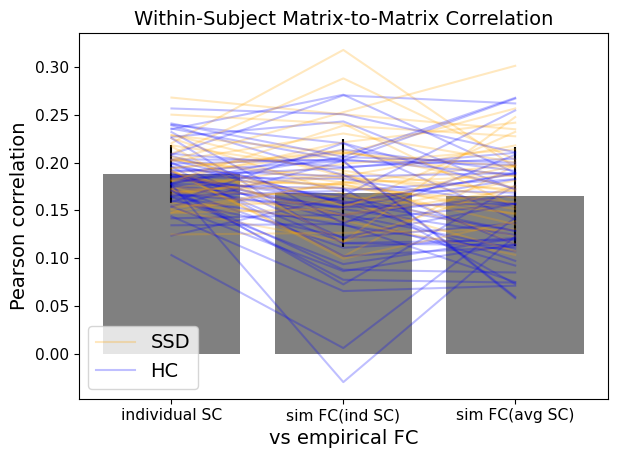

In [54]:
union = Cohort(set.union(low_motion_patients, low_motion_controls))
plot_cohort_connectivity_correlations(union)

In [60]:
import importlib
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

CORTEX = slice(0, 100)

def plot_subject_connectivity(subject):
    structural = subject.structural_connectivity[ATLAS].raw_count
    distances = subject.structural_connectivity[ATLAS].mean_length
    functional = subject.functional_connectivity[ATLAS].correlation_matrix
    simulated = subject.quantities['aln_functional_connectivity']

    structural_cortex = structural[CORTEX, CORTEX]
    distances_cortex = distances[CORTEX, CORTEX]
    functional_cortex = functional[CORTEX, CORTEX]

    plots = []

    plots.append(
        plot.connectivity(
            distances_cortex,
            colorbar=True,
            title="length (mm)",
            output=True,
        )
    )

    plots.append(
        plot.connectivity(
            np.log(structural_cortex + 1e-10),
            colorbar=True,
            title="$log (Fiber count / max)$",
            output=True,
        )
    )

    plots.append(
        plot.connectivity(
            functional_cortex,
            colorbar=True,
            title="empirical",
            output=True,
        )
    )

    plots.append(
        plot.connectivity(
            simulated,
            colorbar=True,
            title="simulated",
            output=True,
        )
    )

    return plots


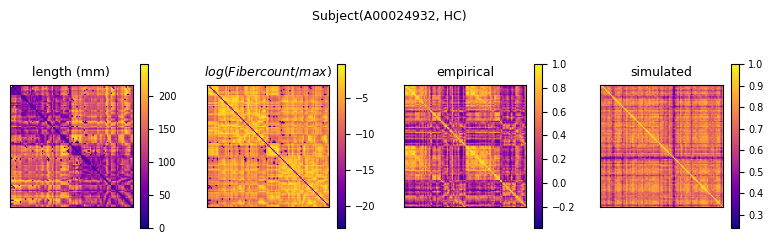

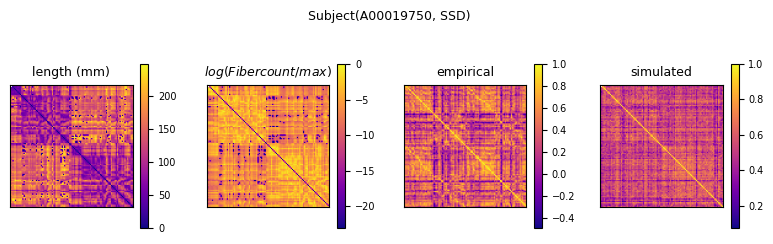

In [62]:
for cohort in (low_motion_controls, low_motion_patients):
    for subject in cohort:
        plots = plot_subject_connectivity(subject)

    plot.compose(
        plots,
        title=subject,
        shape=(1, len(plots)),
        fontsize=9,
        figsize=(8, 2.5),
        output=False,
    )

In [58]:
import numpy as np
import importlib
from schiz_wholebrain import quantities
importlib.reload(quantities)
from schiz_wholebrain.quantities import (
    aln_model, aln_functional_connectivity, matrix2matrix_correlation
)
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

from neurolib.utils.loadData import Dataset

ds = Dataset("gw")

spare_cohort = list(patients - low_motion_patients)
spare_cohort = Cohort(spare_cohort[:5])
print(spare_cohort)

# Replace data with the data from the neurolib sample dataset.
for i, subject in enumerate(spare_cohort):
    subject.structural_connectivity[ATLAS]._raw_count = ds.Cmats[i]
    subject.structural_connectivity[ATLAS]._mean_length = ds.Dmats[i]
    subject.functional_connectivity[ATLAS]._time_series = ds.BOLDs[i].T


Cohort({Subject(A00014590, SSD), Subject(A00001181, SSD), Subject(A00023243, SSD), Subject(A00027391, SSD), Subject(A00001243, SSD)})


  0%|                                         | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████| 5/5 [00:00<00:00, 608.22it/s]

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▍                         | 1/5 [02:20<09:20, 140.05s/it]

 40%|█████████████▏                   | 2/5 [02:20<02:53, 57.85s/it]

 60%|███████████████████▊             | 3/5 [02:20<01:03, 31.50s/it]

 80%|██████████████████████████▍      | 4/5 [02:20<00:19, 19.20s/it]

100%|█████████████████████████████████| 5/5 [02:21<00:00, 12.64s/it]

100%|█████████████████████████████████| 5/5 [02:21<00:00, 28.37s/it]

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▌                          | 1/5 [00:00<00:00,  6.95it/s]

 40%|█████████████▏                   | 2/5 [00:00<00:00,  7.71it/s]

 60%|███████████████████▊             | 3/5 [00:00<00:00,  8.18it/s]

 80%|██████████████████████████▍      | 4/5 [00:00<00:00,  8.45it/s]

100%|█████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▌                          | 1/5 [00:00<00:00,  9.31it/s]

 40%|█████████████▏                   | 2/5 [00:00<00:00,  9.65it/s]

 80%|██████████████████████████▍      | 4/5 [00:00<00:00,  9.98it/s]

100%|█████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▍                         | 1/5 [03:18<13:14, 198.51s/it]

 40%|█████████████▏                   | 2/5 [03:18<04:05, 81.91s/it]

 60%|███████████████████▊             | 3/5 [03:19<01:29, 44.72s/it]

 80%|██████████████████████████▍      | 4/5 [03:20<00:27, 27.64s/it]

100%|█████████████████████████████████| 5/5 [03:20<00:00, 17.77s/it]

100%|█████████████████████████████████| 5/5 [03:20<00:00, 40.20s/it]

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▌                          | 1/5 [00:00<00:01,  2.45it/s]

 40%|█████████████▏                   | 2/5 [00:00<00:01,  2.59it/s]

 60%|███████████████████▊             | 3/5 [00:01<00:00,  2.67it/s]

 80%|██████████████████████████▍      | 4/5 [00:01<00:00,  2.75it/s]

100%|█████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]

100%|█████████████████████████████████| 5/5 [00:01<00:00,  2.82it/s]

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▌                          | 1/5 [00:00<00:01,  2.79it/s]

 40%|█████████████▏                   | 2/5 [00:00<00:01,  2.86it/s]

 60%|███████████████████▊             | 3/5 [00:01<00:00,  2.88it/s]

 80%|██████████████████████████▍      | 4/5 [00:01<00:00,  2.94it/s]

100%|█████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]

100%|█████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]

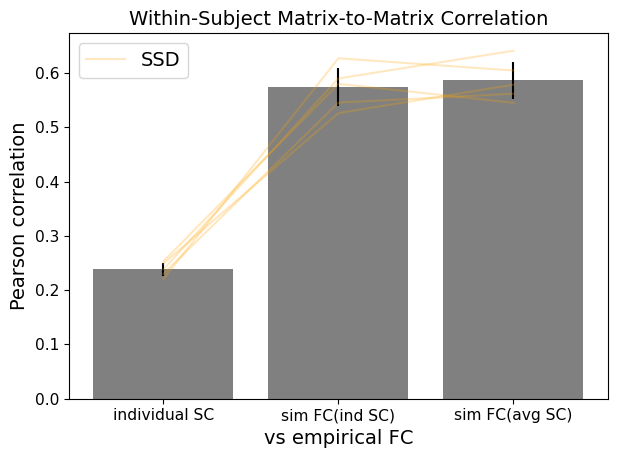

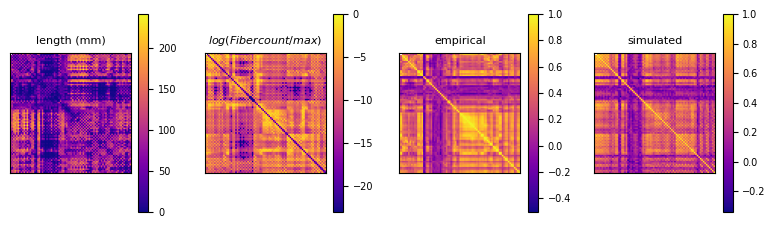

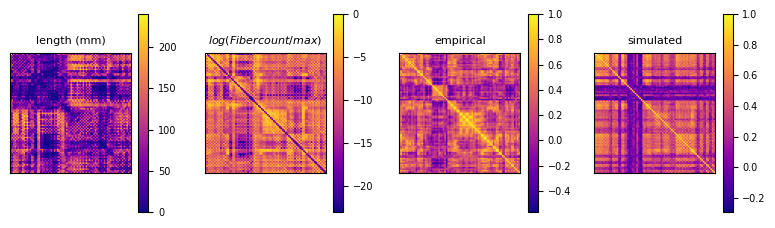

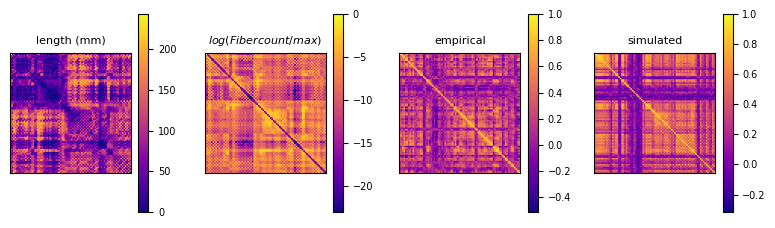

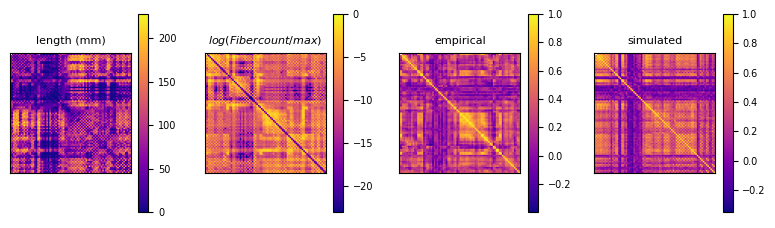

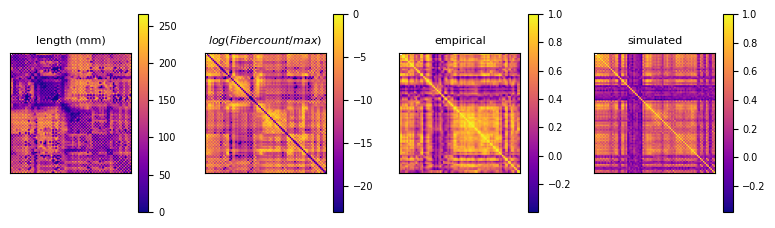

In [59]:
# Correlations with structural connectivity.
compute_cohort_connectivity_correlations(
    spare_cohort,
    bandpass=None,
    sampling_rate=None,
)

# Plot matrix-to-matrix correlation values
plot_cohort_connectivity_correlations(spare_cohort)

# Plot correlation matrices
for subject in spare_cohort:
    plots = plot_subject_connectivity(subject)

    plot.compose(
        plots,
        shape=(1, len(plots)),
        fontsize=8,
        figsize=(8, 2.5),
        output=False,
    )

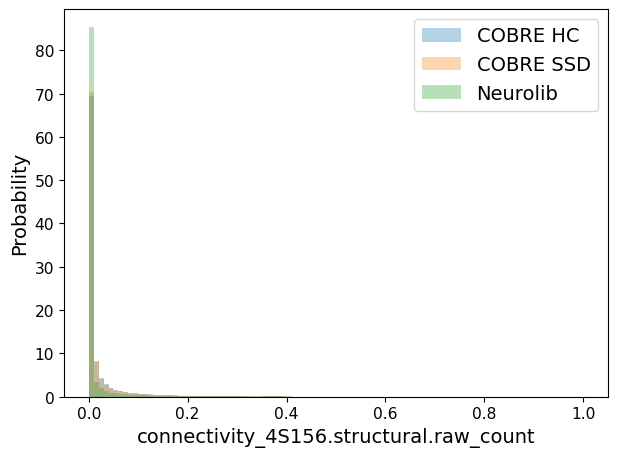

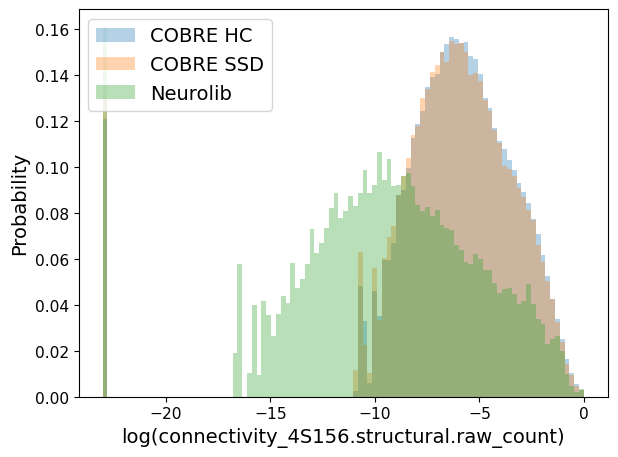

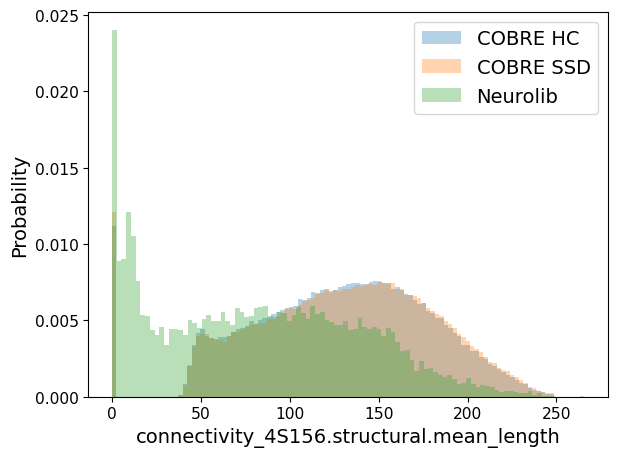

In [ ]:
import importlib
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

quantities = (
    f"connectivity_{ATLAS}.structural.raw_count",
    f"connectivity_{ATLAS}.structural.mean_length",
)

cohorts = {
    "COBRE HC": low_motion_controls,
    "COBRE SSD": low_motion_patients,
    "Neurolib": spare_cohort,
}

for quantity in quantities:
    distributions = dict()

    for cohort_name, cohort in cohorts.items():
        connectivity_matrices = np.stack(
            [matrix[CORTEX, CORTEX] for matrix in cohort.collect(quantity)],
            axis=-1,
        )
        distributions[cohort_name] = connectivity_matrices.ravel()

    plot.distribution(
        distributions,
        axislabels=(quantity, "Probability"),
        density=True,
        bins=100,
    )

    if quantity == f"connectivity_{ATLAS}.structural.raw_count":
        plot.distribution(
            {k: np.log(v + 1e-10) for k, v in distributions.items()},
            axislabels=(f"log({quantity})", "Probability"),
            density=True,
            bins=100
        )

In [63]:
import importlib
from schiz_wholebrain import quantities
importlib.reload(quantities)
from schiz_wholebrain.quantities import connectivity_strength

low_motion_patients.compute(connectivity_strength, max_workers=1, absolute=True)
low_motion_controls.compute(connectivity_strength, max_workers=1, absolute=True)

  0%|                                        | 0/37 [00:00<?, ?it/s]

  3%|▊                               | 1/37 [00:00<00:10,  3.44it/s]

  5%|█▋                              | 2/37 [00:00<00:09,  3.61it/s]

  8%|██▌                             | 3/37 [00:00<00:09,  3.54it/s]

 11%|███▍                            | 4/37 [00:01<00:08,  3.82it/s]

 14%|████▎                           | 5/37 [00:01<00:09,  3.48it/s]

 16%|█████▏                          | 6/37 [00:01<00:08,  3.49it/s]

 19%|██████                          | 7/37 [00:01<00:08,  3.61it/s]

 22%|██████▉                         | 8/37 [00:02<00:08,  3.44it/s]

 24%|███████▊                        | 9/37 [00:02<00:08,  3.28it/s]

 27%|████████▍                      | 10/37 [00:03<00:09,  2.90it/s]

 30%|█████████▏                     | 11/37 [00:03<00:08,  3.03it/s]

 32%|██████████                     | 12/37 [00:03<00:08,  3.09it/s]

 35%|██████████▉                    | 13/37 [00:03<00:07,  3.24it/s]

 38%|███████████▋                   | 14/37 [00:04<00:06,  3.29it/s]

 41%|████████████▌                  | 15/37 [00:04<00:06,  3.62it/s]

 43%|█████████████▍                 | 16/37 [00:04<00:06,  3.23it/s]

 46%|██████████████▏                | 17/37 [00:05<00:06,  3.18it/s]

 49%|███████████████                | 18/37 [00:05<00:05,  3.26it/s]

 51%|███████████████▉               | 19/37 [00:05<00:05,  3.32it/s]

 54%|████████████████▊              | 20/37 [00:06<00:05,  3.19it/s]

 57%|█████████████████▌             | 21/37 [00:06<00:04,  3.27it/s]

 59%|██████████████████▍            | 22/37 [00:06<00:04,  3.20it/s]

 62%|███████████████████▎           | 23/37 [00:07<00:04,  3.09it/s]

 65%|████████████████████           | 24/37 [00:07<00:04,  3.23it/s]

 68%|████████████████████▉          | 25/37 [00:07<00:03,  3.04it/s]

 70%|█████████████████████▊         | 26/37 [00:07<00:03,  3.27it/s]

 73%|██████████████████████▌        | 27/37 [00:08<00:03,  2.86it/s]

 76%|███████████████████████▍       | 28/37 [00:08<00:02,  3.19it/s]

 78%|████████████████████████▎      | 29/37 [00:09<00:02,  2.79it/s]

 81%|█████████████████████████▏     | 30/37 [00:09<00:02,  3.08it/s]

 84%|█████████████████████████▉     | 31/37 [00:09<00:01,  3.35it/s]

 86%|██████████████████████████▊    | 32/37 [00:09<00:01,  3.04it/s]

 89%|███████████████████████████▋   | 33/37 [00:10<00:01,  2.90it/s]

 92%|████████████████████████████▍  | 34/37 [00:10<00:01,  2.87it/s]

 95%|█████████████████████████████▎ | 35/37 [00:11<00:00,  2.97it/s]

 97%|██████████████████████████████▏| 36/37 [00:11<00:00,  2.99it/s]

100%|███████████████████████████████| 37/37 [00:11<00:00,  3.45it/s]

100%|███████████████████████████████| 37/37 [00:11<00:00,  3.21it/s]

  0%|                                        | 0/52 [00:00<?, ?it/s]

  2%|▌                               | 1/52 [00:00<00:11,  4.39it/s]

  4%|█▏                              | 2/52 [00:00<00:10,  4.65it/s]

  6%|█▊                              | 3/52 [00:00<00:10,  4.76it/s]

  8%|██▍                             | 4/52 [00:00<00:10,  4.76it/s]

 10%|███                             | 5/52 [00:01<00:09,  4.74it/s]

 12%|███▋                            | 6/52 [00:01<00:09,  4.90it/s]

 13%|████▎                           | 7/52 [00:01<00:09,  4.68it/s]

 15%|████▉                           | 8/52 [00:01<00:09,  4.72it/s]

 17%|█████▌                          | 9/52 [00:01<00:09,  4.75it/s]

 19%|█████▉                         | 10/52 [00:02<00:08,  4.77it/s]

 21%|██████▌                        | 11/52 [00:02<00:08,  4.76it/s]

 23%|███████▏                       | 12/52 [00:02<00:08,  4.79it/s]

 25%|███████▊                       | 13/52 [00:02<00:07,  4.88it/s]

 27%|████████▎                      | 14/52 [00:02<00:07,  4.88it/s]

 29%|████████▉                      | 15/52 [00:03<00:07,  4.80it/s]

 31%|█████████▌                     | 16/52 [00:03<00:07,  4.74it/s]

 33%|██████████▏                    | 17/52 [00:03<00:07,  4.75it/s]

 35%|██████████▋                    | 18/52 [00:03<00:07,  4.69it/s]

 37%|███████████▎                   | 19/52 [00:03<00:06,  4.82it/s]

 38%|███████████▉                   | 20/52 [00:04<00:06,  4.76it/s]

 40%|████████████▌                  | 21/52 [00:04<00:06,  4.75it/s]

 42%|█████████████                  | 22/52 [00:04<00:06,  4.64it/s]

 44%|█████████████▋                 | 23/52 [00:04<00:06,  4.65it/s]

 46%|██████████████▎                | 24/52 [00:05<00:06,  4.65it/s]

 48%|██████████████▉                | 25/52 [00:05<00:05,  4.63it/s]

 50%|███████████████▌               | 26/52 [00:05<00:05,  4.51it/s]

 52%|████████████████               | 27/52 [00:05<00:05,  4.52it/s]

 54%|████████████████▋              | 28/52 [00:05<00:05,  4.57it/s]

 56%|█████████████████▎             | 29/52 [00:06<00:05,  4.55it/s]

 58%|█████████████████▉             | 30/52 [00:06<00:04,  4.53it/s]

 60%|██████████████████▍            | 31/52 [00:06<00:04,  4.63it/s]

 62%|███████████████████            | 32/52 [00:06<00:04,  4.63it/s]

 63%|███████████████████▋           | 33/52 [00:07<00:04,  4.64it/s]

 65%|████████████████████▎          | 34/52 [00:07<00:03,  4.69it/s]

 67%|████████████████████▊          | 35/52 [00:07<00:03,  4.64it/s]

 69%|█████████████████████▍         | 36/52 [00:07<00:03,  4.71it/s]

 71%|██████████████████████         | 37/52 [00:07<00:03,  4.51it/s]

 73%|██████████████████████▋        | 38/52 [00:08<00:03,  4.43it/s]

 75%|███████████████████████▎       | 39/52 [00:08<00:02,  4.48it/s]

 77%|███████████████████████▊       | 40/52 [00:08<00:02,  4.42it/s]

 79%|████████████████████████▍      | 41/52 [00:08<00:02,  4.41it/s]

 81%|█████████████████████████      | 42/52 [00:09<00:02,  4.56it/s]

 83%|█████████████████████████▋     | 43/52 [00:09<00:02,  4.12it/s]

 85%|██████████████████████████▏    | 44/52 [00:09<00:01,  4.14it/s]

 87%|██████████████████████████▊    | 45/52 [00:09<00:01,  4.25it/s]

 88%|███████████████████████████▍   | 46/52 [00:10<00:01,  4.30it/s]

 90%|████████████████████████████   | 47/52 [00:10<00:01,  4.39it/s]

 92%|████████████████████████████▌  | 48/52 [00:10<00:00,  4.42it/s]

 94%|█████████████████████████████▏ | 49/52 [00:10<00:00,  4.49it/s]

 96%|█████████████████████████████▊ | 50/52 [00:10<00:00,  4.53it/s]

 98%|██████████████████████████████▍| 51/52 [00:11<00:00,  4.57it/s]

100%|███████████████████████████████| 52/52 [00:11<00:00,  4.78it/s]

100%|███████████████████████████████| 52/52 [00:11<00:00,  4.61it/s]

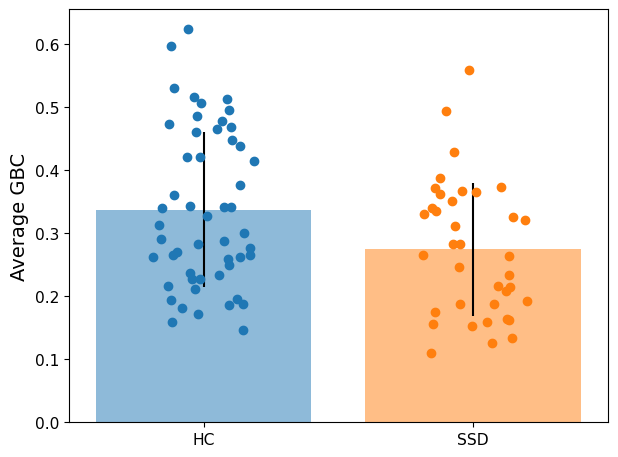

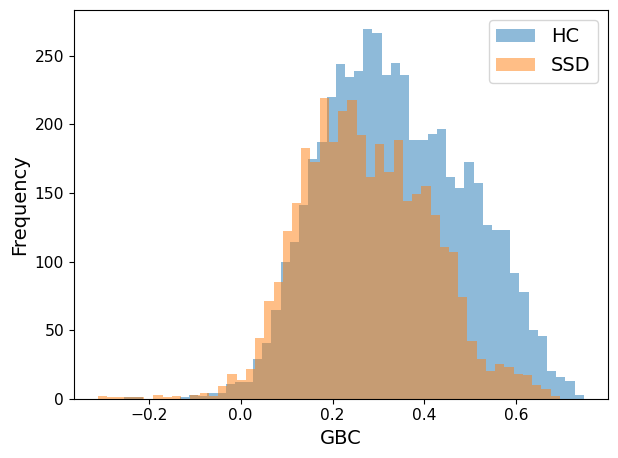

In [64]:
import importlib
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

fcs_patients = low_motion_patients.collect("quantities[connectivity_strength]")
fcs_controls = low_motion_controls.collect("quantities[connectivity_strength]")
fcs_controls = np.array(list(fcs_controls))
fcs_patients = np.array(list(fcs_patients))

plot.scatter(
     {
         "HC": [brain.mean() for brain in fcs_controls],
         "SSD": [brain.mean() for brain in fcs_patients],
     },
     axislabels=("", "Average GBC"),
)

plot.distribution(
    {"HC": np.concatenate(fcs_controls), "SSD": np.concatenate(fcs_patients)},
    axislabels=("GBC", "Frequency"),
    density=False,
    bins=50,
)